# Initial tinkering with E. coli iModulon data to see if we can train a CNN to learn M-matrix values

In [1]:
import pandas as pd
import numpy as np
import utils as u
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats


import altair as alt
import seaborn as sns
import torch_utils as tu

import torch

In [2]:
import utils as u 
import torch_utils as tu
import models as m

from sklearn.metrics import r2_score

from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping,Checkpoint,GradientNormClipping
from skorch.dataset import Dataset
from skorch.helper import predefined_split


## Load data

In [3]:
fname = 'ec_iMod_out/ecoli_seq_M_opFilt.tsv' 
XY = pd.read_csv(fname,sep='\t')
print(XY.shape)
display(XY.head())

loc2seq = dict([(x,z) for (x,z) in XY[['locus_tag','upstream_region']].values])

print(loc2seq['b3575'])

(2129, 99)


,locus_tag,gene,product,type,strand,start,upstream_region,0,1,2,...,82,83,84,85,86,87,88,89,90,91
0,b0005,yaaX,DUF2502 domain-containing protein YaaX,CDS,1,5233,GGCAGAACGTGCTGATTTACCCTTGCTTTCACATAATCTGCCCGCC...,0.008229,-0.000685,-0.005215,...,-0.006856,0.010676,0.008874,0.018497,0.000700,-0.013267,0.015265,0.016886,-0.015319,-0.020727
1,b0007,yaaJ,putative transporter YaaJ,CDS,-1,6528,AGGGAGGTCAATTTGTCCGTCATGATAGTATTTCTCTTTAAACAGC...,0.008111,-0.003929,0.003207,...,-0.000337,-0.010468,0.016122,0.010361,-0.003899,-0.022839,-0.003665,-0.001823,-0.023604,-0.012765
2,b0008,talB,transaldolase B,CDS,1,8237,ATGAAGGAGAAAAAATCTGGCATGCATATCCCTCTTATTGCCGGTC...,0.008629,-0.001270,-0.005664,...,0.000394,0.007215,-0.000707,-0.012959,-0.002329,0.006391,-0.003650,-0.008537,0.002898,-0.000891
3,b0009,mog,molybdopterin adenylyltransferase,CDS,1,9305,AGGGGCTATCGAACGTAAACTGTCTTACACCGGCGAAGTGAAAGCG...,0.002952,0.002053,-0.002882,...,-0.009291,-0.000226,0.016013,0.002179,0.004891,-0.002365,-0.003490,-0.006066,-0.011982,0.011477
4,b0010,satP,acetate/succinate:H(+) symporter,CDS,-1,9927,CATGGTTTGCTGCGCGGCGCGGGGCTGGGAGGCCCTGTAGGTGCGG...,0.006142,0.000884,0.008166,...,-0.009214,-0.010588,0.001363,0.003979,-0.005208,0.003190,-0.015137,-0.005784,-0.001302,0.010800


TCAATCAGCATCAACCCGCGAAACAGACTCTGGCTTCCGGCTGGACGCTCTTTTTCCTGCGCCATCTCGTTCTCTTTTTTTCCCATCACTTCTTTCCCCATTTTGTCGCGTCCTGATGGTAGCGCAAAGTGTGCCGTAGTTCACGATCTCGACAGATAATTTATAACCAATTGATTTTTATGTCTTTTGAAATTCATCAATCAGATTGCCTTGTTAAAAAGTGATCGATATATTTGAAATCAAGTTTCGCATATTGAAATTTTAAGCCAAAAAAGCGATCAAAAAAACAAGGAAGCCTGG


In [4]:
def view_train_test_dist(train_df,test_df,score_cols,title,val_df=None):
    train_df['set'] = 'train'
    test_df['set'] = 'test'
    if val_df is not None:
        val_df['set'] = "val"
        df = pd.concat([train_df,test_df,val_df])
    else:
        df = pd.concat([train_df,test_df])
    
    df_melt = pd.melt(
        df, 
        id_vars=['locus_tag','set'],
        value_vars=score_cols,
        var_name='imod',
        value_name='m_weight'
    )
    
    sns.stripplot(data=df_melt,x='imod',y='m_weight',hue='set',dodge=True,alpha=0.2)
    plt.title(f"{title} distribution")
    plt.show()

(1703, 100)
(426, 100)
(1362, 101)
(341, 101)


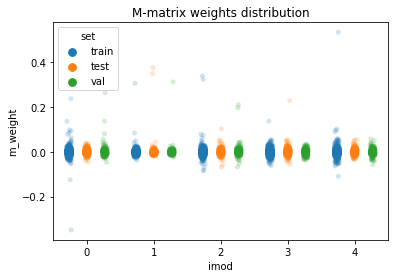

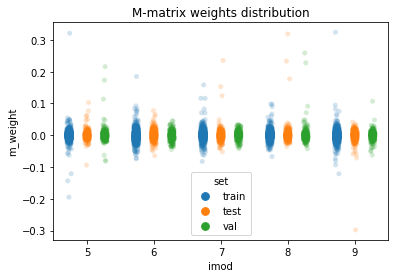

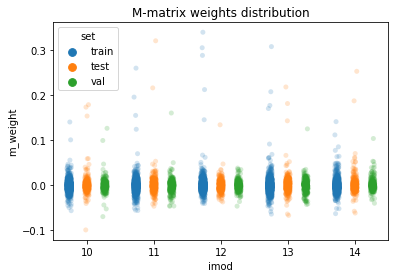

In [5]:
# Split data into train/test/split here and now
full_train_df,test_df = tu.quick_split(XY)
train_df, val_df = tu.quick_split(full_train_df)

print(full_train_df.shape)
print(test_df.shape)
print(train_df.shape)
print(val_df.shape)


coi1 = ['0','1','2','3','4']
coi2 = ['5','6','7','8','9']
coi3 = ['10','11','12','13','14']
assert(train_df.shape[0] + val_df.shape[0] == full_train_df.shape[0])
view_train_test_dist(train_df, test_df,coi1,"M-matrix weights",val_df=val_df)
view_train_test_dist(train_df, test_df,coi2,"M-matrix weights",val_df=val_df)
view_train_test_dist(train_df, test_df,coi3,"M-matrix weights",val_df=val_df)

## convert to skorch-able dfs

In [6]:
# get iModulon column labels
M = pd.read_csv('ec_iMod_out/iMod_download/M.csv',index_col=0)
imods = M.columns
imods[:5]

Index(['0', '1', '2', '3', '4'], dtype='object')

In [7]:
def make_mt_skorch_dfs(df,seq_col='seq',target_cols=['highCu','noCu']):
    '''
    Make multi-task X,y matrix,vec for skorch fit() loop.
    '''
    seqs = list(df[seq_col].values)        
    ohe_seqs = torch.stack([torch.tensor(u.one_hot_encode(x)) for x in seqs])

    # number of labels = len(target_cols)
    labels = torch.tensor(list(df[target_cols].values))
    # bad dimension? fixed in model.forward for now
    
    return ohe_seqs.float(), labels.float()

In [8]:
X, y = make_mt_skorch_dfs(XY, seq_col="upstream_region",target_cols=imods)
print("\nX:",X.shape)
print("y:",y.shape)

Xtrain, ytrain = make_mt_skorch_dfs(train_df, seq_col="upstream_region",target_cols=imods)
print("\nXtrain:",Xtrain.shape)
print("ytrain:",ytrain.shape)

Xval, yval = make_mt_skorch_dfs(val_df, seq_col="upstream_region",target_cols=imods)
print("\nXval:",Xval.shape)
print("yval:",yval.shape)

Xtest, ytest = make_mt_skorch_dfs(test_df, seq_col="upstream_region",target_cols=imods)
print("\nXtest:",Xtest.shape)
print("ytest:",ytest.shape)

Xfull_train, yfull_train = make_mt_skorch_dfs(full_train_df, seq_col="upstream_region",target_cols=imods)
print("\nXfull_train:",Xfull_train.shape)
print("yfull_train:",yfull_train.shape)


X: torch.Size([2129, 300, 4])
y: torch.Size([2129, 92])

Xtrain: torch.Size([1362, 300, 4])
ytrain: torch.Size([1362, 92])

Xval: torch.Size([341, 300, 4])
yval: torch.Size([341, 92])

Xtest: torch.Size([426, 300, 4])
ytest: torch.Size([426, 92])

Xfull_train: torch.Size([1703, 300, 4])
yfull_train: torch.Size([1703, 92])


In [9]:
# make skorch predefined valid ds
# valid_ds = Dataset(Xval, yval)

## pick some params

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [11]:
# just pick some
# Adam, 32 filt, fast LR
# net_regr1 = NeuralNetRegressor(
#     m.DNA_2CNN_Multi, # my pytorch model
#     module__seq_len=300, # pass arg to pytorch model
#     module__n_tasks=ytrain.shape[1],
#     module__num_filters1=64,
#     module__num_filters2=64,
#     module__kernel_size1=12,
#     module__kernel_size2=6,
#     module__conv_pool_size1=3, 
#     module__conv_pool_size2=1,
#     module__fc_node_num1 = 100,
#     module__fc_node_num2 = 10,
#     module__dropout1 = 0.2,
#     module__dropout2 = 0.2,
#     max_epochs=2000,
#     lr=0.01,
#     device=DEVICE,  # uncomment this to train with CUDA
#      callbacks=[
#          EarlyStopping(patience=500),
#          Checkpoint(load_best=True),
#          GradientNormClipping()
#      ],
#     optimizer=torch.optim.SGD,
#     iterator_train__shuffle=True,
#     #train_split=predefined_split(valid_ds)
#     #train_split=None
# )

net_regr1 = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi, # my pytorch model
    module__seq_len=300, # pass arg to pytorch model
    module__n_tasks=ytrain.shape[1],
    module__num_filters1=128,
    module__num_filters2=64,
    module__kernel_size1=8,
    module__kernel_size2=8,
    module__conv_pool_size1=3, 
    module__conv_pool_size2=1,
    module__fc_node_num1 = 100,
    module__fc_node_num2 = 100,
    module__dropout1 = 0.2,
    module__dropout2 = 0.2,
    max_epochs=2000,
    lr=0.01,
    device=DEVICE,  # uncomment this to train with CUDA
     callbacks=[
         EarlyStopping(patience=500),
         Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    optimizer=torch.optim.SGD,
    iterator_train__shuffle=True,
    #train_split=predefined_split(valid_ds)
    #train_split=None
)


In [12]:
net_regr1.fit(Xfull_train, yfull_train)


  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1        0.0038        0.0037     +  1.4518
      2        0.0037        0.0036     +  0.1064
      3        0.0037        0.0036     +  0.1025
      4        0.0036        0.0035     +  0.0822
      5        0.0036        0.0035     +  0.0810
      6        0.0036        0.0034     +  0.0785
      7        0.0035        0.0034     +  0.0779
      8        0.0035        0.0033     +  0.0783
      9        0.0034        0.0033     +  0.0772
     10        0.0034        0.0033     +  0.0761
     11        0.0034        0.0032     +  0.0756
     12        0.0033        0.0032     +  0.0770
     13        0.0033        0.0032     +  0.0763
     14        0.0032        0.0031     +  0.0766
     15        0.0032        0.0031     +  0.0760
     16        0.0032        0.0030     +  0.0760
     17        0.0031        0.0030     +  0.0768
     18        0.0031        0.0030     +  0.0766


    121        0.0014        0.0013     +  0.0765
    122        0.0014        0.0013     +  0.0770
    123        0.0014        0.0013     +  0.0760
    124        0.0014        0.0013     +  0.0758
    125        0.0014        0.0013     +  0.0766
    126        0.0014        0.0013     +  0.0761
    127        0.0014        0.0013     +  0.0761
    128        0.0014        0.0013     +  0.0772
    129        0.0014        0.0013     +  0.0765
    130        0.0014        0.0012     +  0.0777
    131        0.0013        0.0012     +  0.0771
    132        0.0013        0.0012     +  0.0766
    133        0.0013        0.0012     +  0.0780
    134        0.0013        0.0012     +  0.0778
    135        0.0013        0.0012     +  0.0771
    136        0.0013        0.0012     +  0.0768
    137        0.0013        0.0012     +  0.0767
    138        0.0013        0.0012     +  0.0764
    139        0.0013        0.0012     +  0.0772
    140        0.0013        0.0012     +  0.0775


    242        0.0008        0.0007     +  0.0770
    243        0.0008        0.0007     +  0.0777
    244        0.0008        0.0007     +  0.0781
    245        0.0008        0.0007     +  0.0771
    246        0.0008        0.0007     +  0.0760
    247        0.0008        0.0007     +  0.0779
    248        0.0008        0.0007     +  0.0776
    249        0.0008        0.0007     +  0.0765
    250        0.0008        0.0007     +  0.0764
    251        0.0008        0.0007     +  0.0766
    252        0.0008        0.0007     +  0.0763
    253        0.0008        0.0007     +  0.0764
    254        0.0007        0.0007     +  0.0769
    255        0.0007        0.0007     +  0.0776
    256        0.0007        0.0006     +  0.0781
    257        0.0007        0.0006     +  0.0789
    258        0.0007        0.0006     +  0.0784
    259        0.0007        0.0006     +  0.0790
    260        0.0007        0.0006     +  0.0784
    261        0.0007        0.0006     +  0.0785


    364        0.0005        0.0004     +  0.0764
    365        0.0005        0.0004     +  0.0763
    366        0.0005        0.0004     +  0.0767
    367        0.0005        0.0004     +  0.0771
    368        0.0005        0.0004     +  0.0766
    369        0.0005        0.0004     +  0.0775
    370        0.0005        0.0004     +  0.0778
    371        0.0005        0.0004     +  0.0778
    372        0.0005        0.0004     +  0.0773
    373        0.0005        0.0004     +  0.0766
    374        0.0005        0.0004     +  0.0776
    375        0.0005        0.0004     +  0.0778
    376        0.0005        0.0004     +  0.0766
    377        0.0005        0.0004     +  0.0764
    378        0.0005        0.0004     +  0.0764
    379        0.0005        0.0004     +  0.0788
    380        0.0005        0.0004     +  0.0777
    381        0.0005        0.0004     +  0.0765
    382        0.0005        0.0004     +  0.0759
    383        0.0005        0.0004     +  0.0776


    489        0.0004        0.0003     +  0.0780
    490        0.0004        0.0003     +  0.0777
    491        0.0004        0.0003     +  0.0772
    492        0.0004        0.0003     +  0.0780
    493        0.0004        0.0003     +  0.0778
    494        0.0004        0.0003     +  0.0774
    495        0.0004        0.0003     +  0.0766
    496        0.0004        0.0003     +  0.0770
    497        0.0004        0.0003     +  0.0793
    498        0.0004        0.0003     +  0.0812
    499        0.0004        0.0003     +  0.0782
    500        0.0004        0.0003     +  0.0779
    501        0.0004        0.0003     +  0.0775
    502        0.0004        0.0003     +  0.0770
    503        0.0004        0.0003     +  0.0778
    504        0.0004        0.0003     +  0.0778
    505        0.0004        0.0003     +  0.0772
    506        0.0004        0.0003     +  0.0784
    507        0.0004        0.0003     +  0.0779
    508        0.0004        0.0003     +  0.0776


    619        0.0003        0.0003     +  0.0779
    620        0.0003        0.0003     +  0.0789
    621        0.0003        0.0003     +  0.0782
    622        0.0003        0.0003     +  0.0782
    623        0.0003        0.0003     +  0.0774
    624        0.0003        0.0003     +  0.0769
    625        0.0003        0.0003     +  0.0784
    626        0.0003        0.0003     +  0.0788
    627        0.0003        0.0003     +  0.0778
    628        0.0003        0.0003     +  0.0770
    629        0.0003        0.0003     +  0.0782
    630        0.0003        0.0003     +  0.0779
    631        0.0003        0.0003     +  0.0774
    632        0.0003        0.0003     +  0.0776
    633        0.0003        0.0003     +  0.0772
    634        0.0003        0.0003     +  0.0777
    635        0.0003        0.0003     +  0.0768
    636        0.0003        0.0003     +  0.0772
    637        0.0003        0.0003     +  0.0782
    638        0.0003        0.0003     +  0.0780


    752        0.0003        0.0002     +  0.0845
    753        0.0003        0.0002     +  0.0852
    754        0.0003        0.0002     +  0.0844
    755        0.0003        0.0002     +  0.0837
    756        0.0003        0.0002     +  0.0845
    757        0.0003        0.0002     +  0.0842
    758        0.0003        0.0002     +  0.0850
    759        0.0003        0.0002     +  0.0851
    760        0.0003        0.0002     +  0.0852
    761        0.0003        0.0002     +  0.0844
    762        0.0003        0.0002     +  0.0842
    763        0.0003        0.0002     +  0.0845
    764        0.0003        0.0002     +  0.0848
    765        0.0003        0.0002     +  0.0852
    766        0.0003        0.0002     +  0.0852
    767        0.0003        0.0002     +  0.0843
    768        0.0003        0.0002     +  0.0878
    769        0.0003        0.0002     +  0.0883
    770        0.0003        0.0002     +  0.0877
    771        0.0003        0.0002     +  0.0919


    887        0.0003        0.0002     +  0.1086
    888        0.0003        0.0002     +  0.1092
    889        0.0003        0.0002     +  0.1079
    890        0.0003        0.0002     +  0.1083
    891        0.0003        0.0002     +  0.1091
    892        0.0003        0.0002     +  0.1089
    893        0.0003        0.0002     +  0.1090
    894        0.0003        0.0002     +  0.1083
    895        0.0003        0.0002     +  0.1082
    896        0.0003        0.0002     +  0.1079
    897        0.0003        0.0002     +  0.1089
    898        0.0003        0.0002     +  0.1092
    899        0.0003        0.0002     +  0.1088
    900        0.0003        0.0002     +  0.1085
    901        0.0003        0.0002     +  0.1084
    902        0.0003        0.0002     +  0.1091
    903        0.0003        0.0002     +  0.1084
    904        0.0003        0.0002     +  0.1093
    905        0.0003        0.0002     +  0.1090
    906        0.0003        0.0002     +  0.1085


   1023        0.0003        0.0002     +  0.1108
   1024        0.0003        0.0002     +  0.1118
   1025        0.0003        0.0002     +  0.1105
   1026        0.0003        0.0002     +  0.1138
   1027        0.0003        0.0002     +  0.1186
   1028        0.0003        0.0002     +  0.1112
   1029        0.0003        0.0002     +  0.1128
   1030        0.0003        0.0002     +  0.1100
   1031        0.0003        0.0002     +  0.1098
   1032        0.0003        0.0002     +  0.1103
   1033        0.0003        0.0002     +  0.1113
   1034        0.0003        0.0002     +  0.1102
   1035        0.0003        0.0002     +  0.1110
   1036        0.0003        0.0002     +  0.1111
   1037        0.0003        0.0002     +  0.1145
   1038        0.0003        0.0002     +  0.1153
   1039        0.0003        0.0002     +  0.1113
   1040        0.0003        0.0002     +  0.1096
   1041        0.0003        0.0002     +  0.1095
   1042        0.0003        0.0002     +  0.1096


   1161        0.0003        0.0002     +  0.1118
   1162        0.0003        0.0002     +  0.1145
   1163        0.0003        0.0002     +  0.1103
   1164        0.0003        0.0002     +  0.1100
   1165        0.0003        0.0002     +  0.1104
   1166        0.0003        0.0002     +  0.1094
   1167        0.0003        0.0002     +  0.1097
   1168        0.0003        0.0002     +  0.1101
   1169        0.0003        0.0002     +  0.1097
   1170        0.0003        0.0002     +  0.1102
   1171        0.0003        0.0002     +  0.1115
   1172        0.0003        0.0002     +  0.1097
   1173        0.0003        0.0002     +  0.1122
   1174        0.0003        0.0002     +  0.1133
   1175        0.0003        0.0002     +  0.1144
   1176        0.0003        0.0002     +  0.1119
   1177        0.0003        0.0002     +  0.1106
   1178        0.0003        0.0002     +  0.1098
   1179        0.0003        0.0002     +  0.1110
   1180        0.0003        0.0002     +  0.1111


   1300        0.0003        0.0002     +  0.1042
   1301        0.0003        0.0002        0.1062
   1302        0.0003        0.0002     +  0.0998
   1303        0.0003        0.0002     +  0.0858
   1304        0.0003        0.0002     +  0.0877
   1305        0.0003        0.0002     +  0.0858
   1306        0.0003        0.0002     +  0.0856
   1307        0.0003        0.0002     +  0.0862
   1308        0.0003        0.0002        0.0865
   1309        0.0003        0.0002     +  0.0838
   1310        0.0003        0.0002     +  0.0825
   1311        0.0003        0.0002        0.0821
   1312        0.0003        0.0002     +  0.0817
   1313        0.0003        0.0002     +  0.0783
   1314        0.0003        0.0002     +  0.0786
   1315        0.0003        0.0002     +  0.0785
   1316        0.0003        0.0002     +  0.0777
   1317        0.0003        0.0002     +  0.0777
   1318        0.0003        0.0002     +  0.0802
   1319        0.0003        0.0002     +  0.0776


   1440        0.0003        0.0002     +  0.0949
   1441        0.0003        0.0002     +  0.0959
   1442        0.0003        0.0002     +  0.0994
   1443        0.0003        0.0002     +  0.1022
   1444        0.0003        0.0002     +  0.1034
   1445        0.0003        0.0002     +  0.1013
   1446        0.0003        0.0002     +  0.1051
   1447        0.0003        0.0002     +  0.1077
   1448        0.0003        0.0002        0.1088
   1449        0.0003        0.0002        0.1003
   1450        0.0003        0.0002     +  0.0969
   1451        0.0003        0.0002     +  0.0838
   1452        0.0003        0.0002     +  0.0821
   1453        0.0003        0.0002     +  0.0839
   1454        0.0003        0.0002     +  0.0843
   1455        0.0003        0.0002     +  0.0840
   1456        0.0003        0.0002     +  0.0823
   1457        0.0003        0.0002     +  0.0819
   1458        0.0003        0.0002     +  0.0890
   1459        0.0003        0.0002     +  0.0992


   1583        0.0003        0.0002     +  0.0767
   1584        0.0003        0.0002     +  0.0791
   1585        0.0003        0.0002     +  0.0846
   1586        0.0003        0.0002     +  0.0842
   1587        0.0003        0.0002     +  0.0850
   1588        0.0003        0.0002     +  0.0891
   1589        0.0003        0.0002     +  0.0930
   1590        0.0003        0.0002     +  0.0927
   1591        0.0003        0.0002     +  0.0938
   1592        0.0003        0.0002     +  0.0972
   1593        0.0003        0.0002     +  0.0987
   1594        0.0003        0.0002     +  0.1004
   1595        0.0003        0.0002     +  0.1014
   1596        0.0003        0.0002     +  0.1063
   1597        0.0003        0.0002     +  0.1066
   1598        0.0003        0.0002     +  0.1075
   1599        0.0003        0.0002     +  0.1106
   1600        0.0003        0.0002        0.1111
   1601        0.0003        0.0002     +  0.1081
   1602        0.0003        0.0002     +  0.1097


   1724        0.0003        0.0002     +  0.0922
   1725        0.0003        0.0002     +  0.0967
   1726        0.0003        0.0002     +  0.0976
   1727        0.0003        0.0002     +  0.0991
   1728        0.0003        0.0002     +  0.1028
   1729        0.0003        0.0002     +  0.1033
   1730        0.0003        0.0002        0.1075
   1731        0.0003        0.0002        0.1084
   1732        0.0003        0.0002        0.0882
   1733        0.0003        0.0002     +  0.0830
   1734        0.0003        0.0002     +  0.0781
   1735        0.0003        0.0002     +  0.0789
   1736        0.0003        0.0002     +  0.0799
   1737        0.0003        0.0002     +  0.0785
   1738        0.0003        0.0002     +  0.0827
   1739        0.0003        0.0002     +  0.0791
   1740        0.0003        0.0002        0.0781
   1741        0.0003        0.0002        0.0765
   1742        0.0003        0.0002     +  0.0772
   1743        0.0003        0.0002     +  0.0799


   1866        0.0003        0.0002     +  0.0809
   1867        0.0003        0.0002     +  0.0822
   1868        0.0003        0.0002        0.0808
   1869        0.0003        0.0002     +  0.0798
   1870        0.0003        0.0002     +  0.0783
   1871        0.0003        0.0002     +  0.0779
   1872        0.0003        0.0002     +  0.0778
   1873        0.0003        0.0002     +  0.0787
   1874        0.0003        0.0002     +  0.0790
   1875        0.0003        0.0002     +  0.0795
   1876        0.0003        0.0002     +  0.0932
   1877        0.0003        0.0002     +  0.0946
   1878        0.0003        0.0002     +  0.0972
   1879        0.0003        0.0002     +  0.0983
   1880        0.0003        0.0002     +  0.1018
   1881        0.0003        0.0002        0.1048
   1882        0.0003        0.0002     +  0.0979
   1883        0.0003        0.0002     +  0.0932
   1884        0.0003        0.0002     +  0.0935
   1885        0.0003        0.0002        0.0947


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 128, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 3), stride=(1, 3), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(128, 64, kernel_size=(1, 8), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.2, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=5760, out_features=100, bias=True)
      (9): ReLU()
      (10): Linear(in_features=100, out_features=100, bias=True)
      (11): ReLU()
      (12): Linear(in_features=100, out_features=92, bias=True)
    )
  ),
)

# Viz model results

In [16]:
def sk_loss_plot(nets,yscaler=5):
    '''
    Draw the train/val losses from a skorch net
    '''
    
    fig = plt.figure(figsize=(10,5))
    smallest_val = 999
    for i,(net,name) in enumerate(nets):
        # plot net_regr's loss trace
        train_loss = net.history[:, 'train_loss']
        valid_loss = net.history[:, 'valid_loss']
        
        plt.plot(train_loss,'-',color=f"C{i}", label=f"{name} Train",linewidth=1.0,alpha=0.5)
        plt.plot(valid_loss,'-',color=f"C{i}", label=f"{name} Val",linewidth=3.0,alpha=0.5)
        
        val_min_ep,val_min = min(enumerate(valid_loss),key = lambda t: t[1])
        plt.axhline(val_min,linestyle='--',c=f"C{i}",linewidth=0.5)
        plt.axvline(val_min_ep,linestyle='--',c=f"C{i}",linewidth=0.5)
        #plt.axhline(5,c='k')
        
        if val_min < smallest_val:
            smallest_val = val_min

    plt.ylim(0,smallest_val*yscaler)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("MSE Loss",fontsize=14)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()
    
def parity_plot(title,ytrue,ypred, r2,rigid=False):
    plt.scatter(ytrue, ypred, alpha=0.2)
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    #plt.title(f"{model_name} (pearson:{pearson:.3f})",fontsize=20)
    plt.title(f"{title} (r2:{r2:.3f})",fontsize=20)
    plt.show()

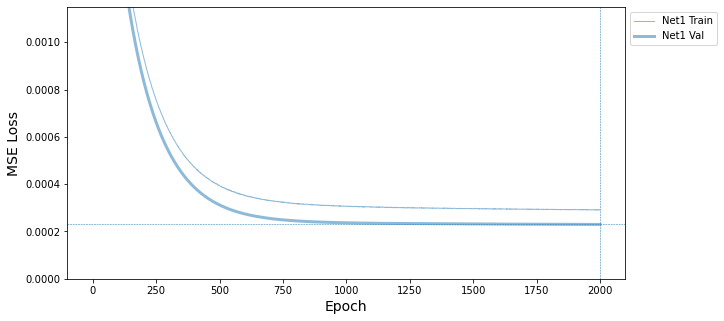

In [17]:
nets = [
    (net_regr1,'Net1'),
]

sk_loss_plot(nets)

YTRUE torch.Size([1362, 92])
**** ave r2:     -0.039238807512268846
**** r2 overall: -0.03923880763810432
YTRUE torch.Size([341, 92])
**** ave r2:     -0.04556930561581869
**** r2 overall: -0.04556930670708684


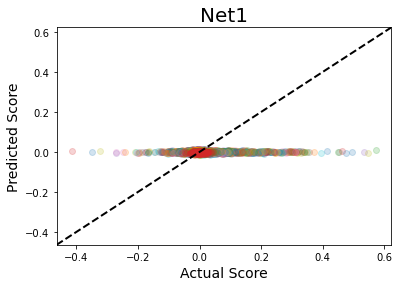

In [18]:
def parity_plot_comb(title,true_preds,rigid=True,make_legend=True):
    all_net_r2s = []
    for (ytrue, ypred,name) in true_preds:
        print("YTRUE",ytrue.shape)
#         print("YPRED",ypred.shape)
        r2s = []
        for i in range(ytrue.shape[1]):
            ytruei = ytrue[:,i]
            ypredi = ypred[:,i]
            r2i = r2_score(ytruei,ypredi)
            #print(f"r2 {i}", r2i)
            r2s.append(r2i)
            plt.scatter(ytruei, ypredi, alpha=0.2,label=f"{i} (r2:{r2i:.3f})")
            
        r2 = r2_score(ytrue,ypred)
        r2i_mean = np.mean(r2s)
        print(f"**** ave r2:    ", r2i_mean)
        print(f"**** r2 overall:", r2)
        
        #plt.scatter(ytrue, ypred, alpha=0.2,label=f"{name} (r2:{r2:.3f})")
    
    # y=x line
    xpoints = ypoints = plt.xlim()
    if rigid:
        plt.ylim(min(xpoints),max(xpoints)) 
    plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=2, scalex=False, scaley=False)

    plt.xlabel("Actual Score",fontsize=14)
    plt.ylabel("Predicted Score",fontsize=14)
    plt.title(f"{title}",fontsize=20)
    if make_legend:
        plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.show()

def view_preds(nets,make_legend=True):
    # for each network to plot
    for (net,name) in nets:
        ytrain_pred = net.predict(Xtrain)
        yval_pred = net.predict(Xval)

        plot_list = [
            (ytrain,ytrain_pred,"train"),
            (yval,yval_pred,"val"),
        ]
        parity_plot_comb(name, plot_list,rigid=True,make_legend=make_legend)


#view_preds(nets[::-1])
view_preds(nets,make_legend=False)

In [19]:
def view_multi_parity(title,ytrue,ypred,rigid=True, num_cols=8):
        
    num_plts = ytrue.shape[1]
    num_rows = int(np.ceil(num_plts/num_cols))
    
    max_point = max(max(ytrue.flatten()),max(ypred.flatten()))
    min_point = min(min(ytrue.flatten()),min(ypred.flatten()))
    
    plt.figure(figsize=(15, 20))
    

    for c in range(ytrue.shape[1]):
        ax1 = plt.subplot(num_rows, num_cols,c+1)
        yt = ytrue[:,c]
        yp = ypred[:,c]
        p = scipy.stats.pearsonr(yt,yp)[0]
        r2 = r2_score(yt,yp)
        
        ax1.scatter(yt,yp,color=f'C{c}',label=c,alpha=0.2)
        ax1.set_title(f"{c} (r2:{r2:.3f})")
        if rigid:
            plt.ylim(min_point,max_point)
        ax1.plot([min_point,max_point], [min_point,max_point], linestyle='--', color='k', lw=2, scalex=False, scaley=False)
        
    plt.suptitle(title,fontsize=22)
    plt.xlabel("Actual Value")
    plt.ylabel("Predicted Value")
    plt.tight_layout()
    
def view_multi_train_test_parity(
    title,
    ytrain_true,
    ytrain_pred,
    ytest_true,
    ytest_pred,
    rigid=True, 
    num_cols=2):

    num_plts = ytrain_true.shape[1]
    num_rows = int(np.ceil(num_plts/num_cols))
    
    max_point = max(max(ytrain_true.flatten()),max(ytrain_pred.flatten()))
    min_point = min(min(ytrain_true.flatten()),min(ytrain_pred.flatten()))
    
    plt.figure(figsize=(10, 20))
    
    # loop through conditions
    for c in cond_dict:
        ytrain_t = ytrain_true[:,c]
        ytrain_p = ytrain_pred[:,c]
        ytest_t = ytest_true[:,c]
        ytest_p = ytest_pred[:,c]
        
        r2tr  = r2_score(ytrain_t,ytrain_p)
        r2te  = r2_score(ytest_t,ytest_p)
        
        
        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols,c+1)
        
        ax1.scatter(ytrain_t,ytrain_p,alpha=0.07,label=f"Train (r2:{r2tr:.3f})")
        ax1.scatter(ytest_t,ytest_p,alpha=0.07,label=f"Test (r2:{r2te:.3f})")
        
        #ax1.set_title(f"{cond_dict[c]} (pearsonr:{p:.3f})")
        ax1.set_title(f"{cond_dict[c]}")
        if rigid:
            plt.ylim(min_point,max_point)
        ax1.plot([min_point,max_point], [min_point,max_point], linestyle='--', color='k', lw=2, scalex=False, scaley=False)
        plt.xlabel("Actual Value")
        plt.ylabel("Predicted Value")
        plt.legend(loc='best')

    plt.suptitle(title,fontsize=22)
    
    plt.tight_layout()

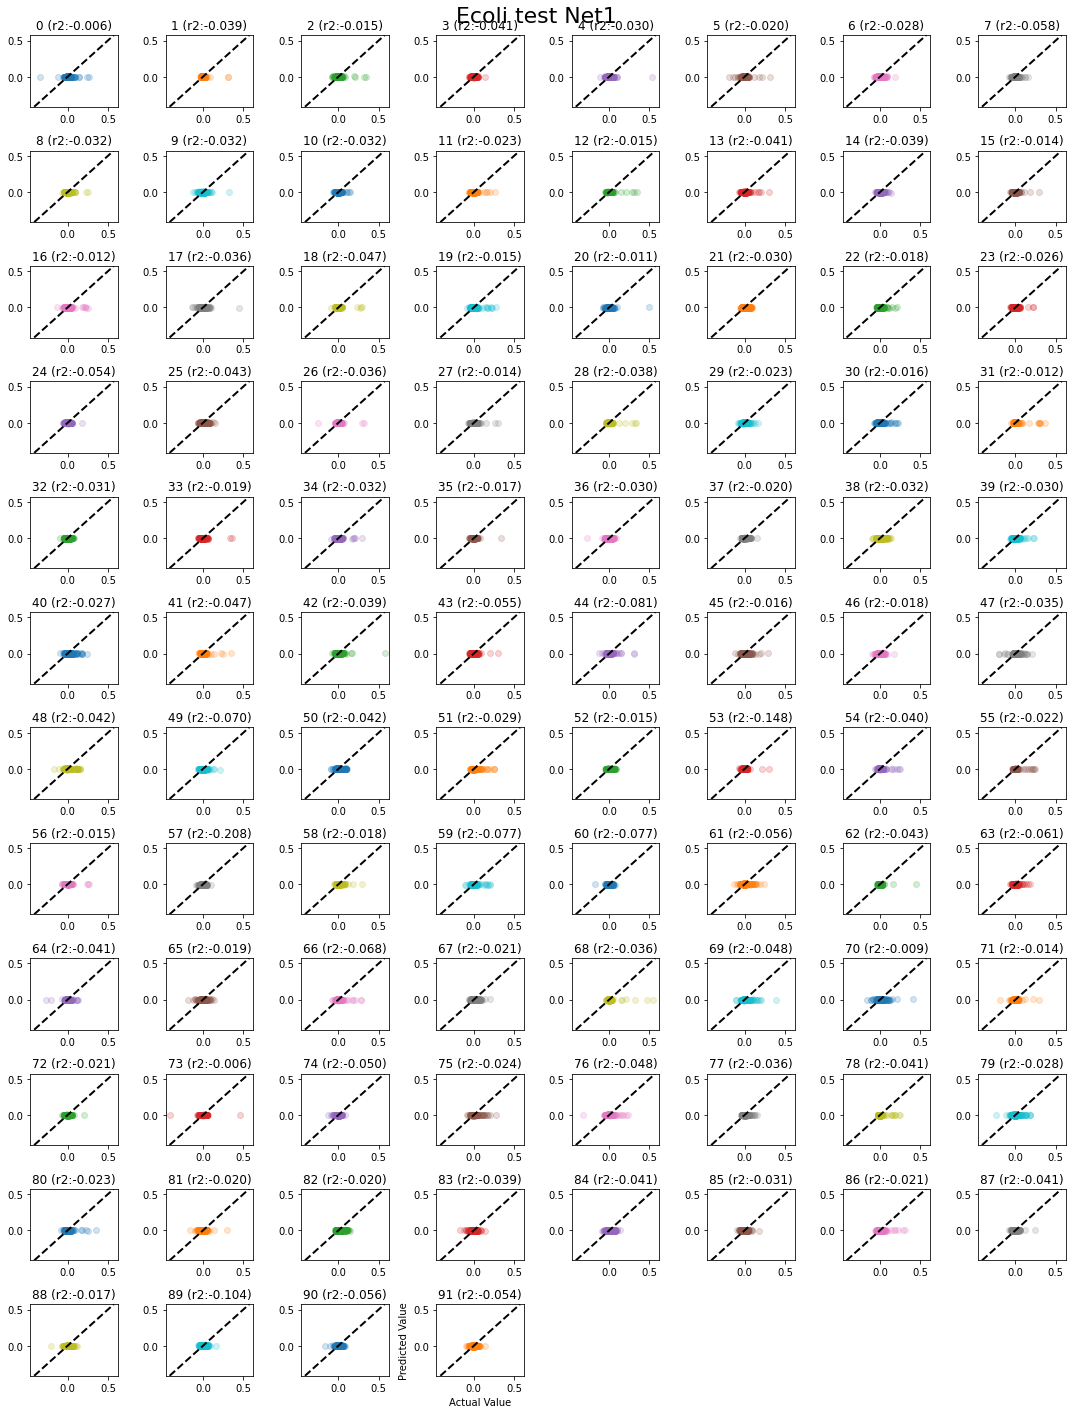

In [20]:
yfull_train_pred = net_regr1.predict(Xfull_train)

view_multi_parity("Ecoli test Net1", 
    yfull_train, 
    yfull_train_pred,
    rigid=True)

For all tasks, defaulting to about 0, aka "not in iModulon"
* are any iMods better than others?
* do an initial skorch search to see if any hyperparams stand out?
* then dip back to data aug... cross val
* mbinarized



# SKORCH search

In [21]:
from sklearn.model_selection import RandomizedSearchCV


In [22]:
net_search = NeuralNetRegressor(
    m.DNA_2CNN_2FC_Multi,
    #m.DNA_2CNN_Multi,
    #m.DNA_CNN_Multi,
    module__seq_len=300,
    module__n_tasks=y.shape[1],
    max_epochs=2000,
    #lr=0.001,
    device=DEVICE,
    callbacks=[
         EarlyStopping(patience=500),
         #Checkpoint(load_best=True),
         GradientNormClipping()
     ],
    verbose=0,

)

In [24]:
params = {
    'lr': [0.01, 0.001, 0.0001,],#loguniform(0.0001, 0.01)
    
    'module__num_filters1': [16,32,64,128],
    'module__num_filters2': [16,32,64,128],
    'module__kernel_size1': [4,8,16,32],
    'module__kernel_size2': [4,8,16,32],
    'module__conv_pool_size1': [2,4,8,16],
    'module__fc_node_num1': [10,50,100,500],
    'module__fc_node_num2': [10,50,100,500],
    'module__dropout1': [0.0,0.2,0.4],
    'module__dropout2': [0.0,0.2,0.4],
    'optimizer':[torch.optim.SGD, torch.optim.Adam,torch.optim.AdamW,torch.optim.RMSprop]
}

In [25]:
search = RandomizedSearchCV(
    net_search, 
    params, 
    n_iter=100, 
    #scoring='neg_mean_absolute_error', 
    scoring='neg_mean_squared_error', 
    n_jobs=-1, 
    cv=3,#cv, 
    random_state=7,
    verbose=1
)

In [26]:
search.fit(Xfull_train,yfull_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 102.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 136.9min finished


RandomizedSearchCV(cv=3,
                   estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class 'models.DNA_2CNN_2FC_Multi'>,
  module__n_tasks=92,
  module__seq_len=300,
),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'lr': [0.01, 0.001, 0.0001],
                                        'module__conv_pool_size1': [2, 4, 8,
                                                                    16],
                                        'module__dropout1': [0.0, 0.2, 0.4],
                                        'module__dropout2': [0.0, 0.2, 0.4],
                                        'mo...
                                                                 500],
                                        'module__kernel_size1': [4, 8, 16, 32],
                                        'module__kernel_size2': [4, 8, 16, 32],
                                        'module__num_filters1': [16, 32, 64,
                    

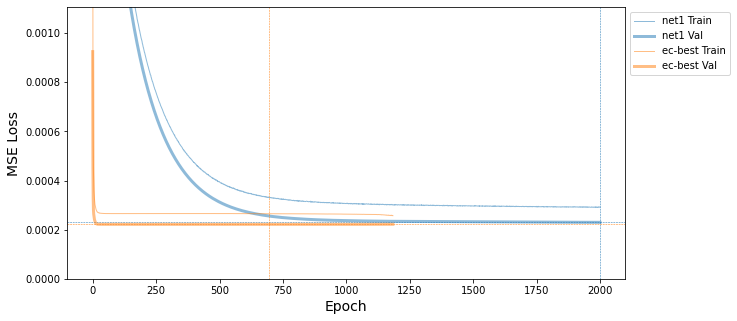

In [28]:
nets = [
    (net_regr1,"net1"),
    (search.best_estimator_,'ec-best')
]

sk_loss_plot(nets)

### inspect hyperparam search results

In [29]:
search.best_estimator_

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=DNA_2CNN_2FC_Multi(
    (conv_net): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 8), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 16), stride=(1, 16), padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.4, inplace=False)
      (4): Conv2d(16, 128, kernel_size=(1, 16), stride=(1, 1))
      (5): ReLU()
      (6): Dropout(p=0.4, inplace=False)
      (7): Flatten()
      (8): Linear(in_features=384, out_features=50, bias=True)
      (9): ReLU()
      (10): Linear(in_features=50, out_features=500, bias=True)
      (11): ReLU()
      (12): Linear(in_features=500, out_features=92, bias=True)
    )
  ),
)

In [30]:
search.best_params_

{'optimizer': torch.optim.adamw.AdamW,
 'module__num_filters2': 128,
 'module__num_filters1': 16,
 'module__kernel_size2': 16,
 'module__kernel_size1': 8,
 'module__fc_node_num2': 500,
 'module__fc_node_num1': 50,
 'module__dropout2': 0.4,
 'module__dropout1': 0.4,
 'module__conv_pool_size1': 16,
 'lr': 0.0001}

In [31]:
res_df = pd.DataFrame(search.cv_results_)
res_df['opt_name'] = res_df['param_optimizer'].apply(lambda x: x.__name__)
res_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer,param_module__num_filters2,param_module__num_filters1,param_module__kernel_size2,param_module__kernel_size1,param_module__fc_node_num2,...,param_module__conv_pool_size1,param_lr,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,opt_name
0,71.967057,12.216083,0.021500,0.001165,<class 'torch.optim.rmsprop.RMSprop'>,128,64,16,4,10,...,16,0.01,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000296,-0.000311,-0.000346,-0.000318,0.000021,72,RMSprop
1,163.493714,9.668032,0.018877,0.001166,<class 'torch.optim.sgd.SGD'>,32,16,32,4,50,...,2,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.006479,-0.007145,-0.006745,-0.006790,0.000274,92,SGD
2,41.803676,1.812703,0.021897,0.002649,<class 'torch.optim.adam.Adam'>,64,32,4,16,10,...,16,0.01,"{'optimizer': <class 'torch.optim.adam.Adam'>,...",-0.000237,-0.000253,-0.000289,-0.000260,0.000022,16,Adam
3,0.007967,0.000205,0.000000,0.000000,<class 'torch.optim.adamw.AdamW'>,32,128,32,8,100,...,16,0.01,{'optimizer': <class 'torch.optim.adamw.AdamW'...,NaN,NaN,NaN,NaN,NaN,100,AdamW
4,67.520009,29.807880,0.017562,0.000624,<class 'torch.optim.rmsprop.RMSprop'>,16,32,32,4,10,...,4,0.001,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000239,-0.000255,-0.000291,-0.000262,0.000022,23,RMSprop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,46.600638,20.220994,0.017378,0.000783,<class 'torch.optim.rmsprop.RMSprop'>,16,16,8,32,50,...,4,0.01,{'optimizer': <class 'torch.optim.rmsprop.RMSp...,-0.000296,-0.000308,-0.000346,-0.000317,0.000021,63,RMSprop
96,74.883984,12.679929,0.018746,0.001701,<class 'torch.optim.adamw.AdamW'>,128,64,8,16,10,...,8,0.0001,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-0.000429,-0.000292,-0.000362,-0.000361,0.000056,78,AdamW
97,123.845607,46.760401,0.020805,0.000315,<class 'torch.optim.adamw.AdamW'>,128,16,16,16,10,...,8,0.0001,{'optimizer': <class 'torch.optim.adamw.AdamW'...,-0.000242,-0.000269,-0.000297,-0.000270,0.000022,42,AdamW
98,178.359135,2.837735,0.022018,0.003054,<class 'torch.optim.sgd.SGD'>,128,128,8,16,10,...,16,0.0001,"{'optimizer': <class 'torch.optim.sgd.SGD'>, '...",-0.030090,-0.036958,-0.036385,-0.034478,0.003112,96,SGD


In [32]:
sm_res_df = res_df[[
    "rank_test_score",
    "mean_test_score",
    "param_module__num_filters1",
    "param_module__num_filters2",
    "param_module__kernel_size1",
    "param_module__kernel_size2",
    "param_lr",
    "param_module__fc_node_num1",
    "param_module__fc_node_num2",
    "opt_name"]]

In [33]:
sm_res_df

,rank_test_score,mean_test_score,param_module__num_filters1,param_module__num_filters2,param_module__kernel_size1,param_module__kernel_size2,param_lr,param_module__fc_node_num1,param_module__fc_node_num2,opt_name
0,72,-0.000318,64,128,4,16,0.01,500,10,RMSprop
1,92,-0.006790,16,32,4,32,0.0001,100,50,SGD
2,16,-0.000260,32,64,16,4,0.01,10,10,Adam
3,100,NaN,128,32,8,32,0.01,100,100,AdamW
4,23,-0.000262,32,16,4,32,0.001,50,10,RMSprop
...,...,...,...,...,...,...,...,...,...,...
95,63,-0.000317,16,16,32,8,0.01,50,50,RMSprop
96,78,-0.000361,64,128,16,8,0.0001,50,10,AdamW
97,42,-0.000270,16,128,16,16,0.0001,500,10,AdamW
98,96,-0.034478,128,128,16,8,0.0001,50,10,SGD


In [34]:
alt.Chart(sm_res_df).mark_point().encode(
    x='rank_test_score:Q',
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
#     column='param_module__num_filters:N',
#     detail='model_desc:N',
    #shape="param_module__kernel_size1:N"
    
).interactive()

alt.Chart(...)

In [35]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__kernel_size1:O',title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='param_module__num_filters1:N',
#     detail='model_desc:N',
    shape="opt_name:N",
    tooltip=["rank_test_score:O","param_module__num_filters1:N","param_module__kernel_size1:N","param_lr:N","param_module__fc_node_num1:N"]
    
).interactive()

alt.Chart(...)

In [37]:
alt.Chart(sm_res_df).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [38]:
alt.Chart(sm_res_df[~sm_res_df['opt_name'].isin(['SGD'])]).mark_boxplot(extent='min-max').encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    #color=alt.Color('param_lr:N',scale=alt.Scale(scheme='tableau10')),
    column='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [39]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__num_filters1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__kernel_size1:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [41]:
alt.Chart(sm_res_df).mark_point(size=100).encode(
    x=alt.X('param_module__fc_node_num1:O'),#title="kernel size 1"),
    y='mean_test_score:Q',
    color=alt.Color('rank_test_score:Q',scale=alt.Scale(scheme='viridis')),
    column='param_module__fc_node_num2:N',
    shape='opt_name:N',
    row='param_lr:N',
).interactive(
).properties(
    height=100,
    width=100
)

alt.Chart(...)

In [42]:
res_df.to_csv('ec_iMod_out/hyper100_1.tsv',sep='\t',index=False)

# Next ideas
* Retry with data aug 
* gradient clipping


# NOTE: 
--> using "load_best" = True seems to work now?? Stops on the final one